In [ ]:
# ✅ 경로/파라미터 설정
IMAGES_DIR = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\angle_velocity_data\tilt5\images_ud"  # 스캔 이미지 폴더 경로 (같은 폴더면 ".")
YOLO_MODEL_PATH = r"C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\dataset\runs\detect\train_y8m_ud2\weights\best.pt"  # YOLO 가중치(.pt)
CLASS_ID = None
CONF_TH  = 0.10      # YOLO confidence threshold
TILT_ABS_MAX = 0.5   # |tilt| ≤ 이 값인 샘플만 사용

# 파일명에서 pan/tilt 파싱 (예: img_t+00_p-010_*.jpg)
FNAME_REGEX = r"img_t(?P<tilt>[+-]?\d+(?:\.\d+)?)_p(?P<pan>[+-]?\d+(?:\.\d+)?)_.*\.(?:jpg|jpeg|png)$"

# ✅ YOLO 시각화 저장 옵션 (추가)
SAVE_ANNOTATED_IMG = True           # True면 YOLO 결과 그려 저장
OUT_VIS_DIR = "./yolo_vis"          # 저장 폴더

from pathlib import Path
Path(OUT_VIS_DIR).mkdir(parents=True, exist_ok=True)

print('IMAGES_DIR =', IMAGES_DIR)
print('YOLO_MODEL_PATH =', YOLO_MODEL_PATH)


IMAGES_DIR = C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\captures_gui_20250929_180453\images_ud
YOLO_MODEL_PATH = C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\dataset\runs\detect\train_y8m_ud2\weights\best.pt


In [7]:
import re, json, csv
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt  # 그래프 표시(색 지정 X)

try:
    from ultralytics import YOLO
except Exception as e:
    raise RuntimeError("Ultralytics YOLO가 설치되어 있지 않습니다.\npip install ultralytics")


In [8]:
def find_images(root: Path):
    imgs = []
    for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
        imgs.extend(root.rglob(ext))
    return sorted(imgs)

def parse_angles(name: str, patt: re.Pattern):
    m = patt.search(name)
    if not m: 
        return None
    try:
        pan = float(m.group("pan")); tilt = float(m.group("tilt"))
        return pan, tilt
    except Exception:
        return None

def pick_box(result, W, H, class_id=None, conf_th=0.0):
    """
    필터 최소화: 클래스/CONF/중앙성 전부 무시하고
    감지된 것 중 conf 최고 하나만 반환.
    반환: (x1,y1,x2,y2,conf,cls) 또는 None
    """
    if result is None or result.boxes is None or len(result.boxes) == 0:
        return None
    best = None
    best_conf = -1.0
    for b in result.boxes:
        conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
        x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().tolist()
        cls = int(b.cls.cpu().item()) if b.cls is not None else -1
        if conf > best_conf:
            best_conf = conf
            best = (x1,y1,x2,y2,conf,cls)
    return best



def linearity_metrics(pan_deg, cx_px, W_frame):
    x = np.asarray(pan_deg, float)
    y = np.asarray(cx_px, float)
    if len(x) < 3 or np.std(x) < 0.5:  # 샘플 부족 또는 스윕 폭 부족
        return None
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]  # y ≈ a*x + b
    yhat = a*x + b
    resid = y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - float(y.mean()))**2))
    R2 = 1.0 - ss_res/ss_tot if ss_tot>0 else 1.0
    max_abs_resid = float(np.max(np.abs(resid)))
    slopes = np.diff(y) / np.diff(x)
    slope_cov = float(np.std(slopes) / (np.mean(slopes)+1e-9))
    deg_per_px_x = 1.0 / a if abs(a) > 1e-9 else None
    pan_center = ((W_frame/2.0) - b) / a if abs(a) > 1e-9 else None
    return dict(a=float(a), b=float(b), R2=R2, max_resid_px=max_abs_resid,
                slope_cov=slope_cov, deg_per_px_x=deg_per_px_x, pan_center=pan_center)

def plot_scatter_pan_cx(x, y, a, b, out_png=None):
    plt.figure()
    plt.scatter(x, y, s=12, label="samples")
    xx = np.linspace(min(x), max(x), 200)
    yy = a*xx + b
    plt.plot(xx, yy, label=f"fit: y={a:.3f}x+{b:.2f}")
    plt.xlabel("pan (deg)")
    plt.ylabel("cx (px)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png)
    plt.show()

def save_annotated_image(img_bgr, res, out_png_path):
    """YOLO 박스 전부(녹색) 그려서 PNG로 저장"""
    vis = img_bgr.copy()
    if res is not None and res.boxes is not None and len(res.boxes) > 0:
        for b in res.boxes:
            conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
            x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
            cls = int(b.cls.cpu().item()) if b.cls is not None else -1
            p1, p2 = (int(x1), int(y1)), (int(x2), int(y2))
            cv2.rectangle(vis, p1, p2, (0,255,0), 2)
            cv2.putText(vis, f"{cls}:{conf:.2f}", (p1[0], max(15,p1[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
    ok, buf = cv2.imencode(".png", vis)
    if ok:
        buf.tofile(str(out_png_path))  # Windows 한글 경로 안전 저장


In [9]:
img_dir = Path(IMAGES_DIR)
assert img_dir.exists(), f"이미지 폴더가 존재하지 않습니다: {img_dir}"

# 폴더를 넣었을 경우 자동으로 best/last.pt 잡아주기(안전장치)
p = Path(YOLO_MODEL_PATH)
if p.is_dir():
    cand = list(p.glob("best*.pt")) + list(p.glob("last*.pt")) + list(p.glob("*.pt"))
    assert cand, f"'{p}' 폴더 안에 .pt 파일이 없습니다."
    YOLO_MODEL_PATH = str(cand[0])

model = YOLO(YOLO_MODEL_PATH)

patt = re.compile(FNAME_REGEX)
files = find_images(img_dir)
print(f"Found {len(files)} image files")
# print(files[:10])  # 필요시 확인


Found 242 image files


In [10]:
# YOLO 추론 → (pan, cx) 수집 (tilt≈0만) — CONF_TH 이상인 모든 박스 저장
rows = []
W_frame = None

# 선택: 특정 클래스만 쓸 거면 숫자, 전부 쓰려면 None
USE_CLASS_ID = None  # 예: 0  (혹은 None)

for fp in files:
    m = patt.search(fp.name)
    if not m:
        continue
    pan_deg = float(m.group("pan"))
    tilt_deg = float(m.group("tilt"))
    if abs(tilt_deg) > TILT_ABS_MAX:
        continue  # tilt≈0만 사용

    img = cv2.imdecode(np.fromfile(str(fp), dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        continue
    H, W = img.shape[:2]
    if W_frame is None:
        W_frame = W

    # ★ 여기서부터 conf=CONF_TH 를 그대로 사용
    res = model.predict(source=img, imgsz=max(W, H), conf=CONF_TH, verbose=False)[0]

    # (옵션) YOLO 결과 시각화 저장
    if SAVE_ANNOTATED_IMG and res is not None:
        out_png = Path(OUT_VIS_DIR) / f"{Path(fp).stem}.png"
        save_annotated_image(img, res, out_png)

    if res is None or res.boxes is None or len(res.boxes) == 0:
        continue

    # CONF_TH 이상, (옵션) 클래스 매칭되는 모든 박스 저장
    kept = 0
    for b in res.boxes:
        conf = float(b.conf.cpu().item()) if b.conf is not None else 0.0
        if conf < CONF_TH:
            continue
        cls = int(b.cls.cpu().item()) if b.cls is not None else -1
        if (USE_CLASS_ID is not None) and (cls != USE_CLASS_ID):
            continue

        x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
        cx = 0.5 * (x1 + x2)
        cy = 0.5 * (y1 + y2)

        rows.append({
            "file": fp.name,
            "pan_deg": pan_deg,
            "tilt_deg": tilt_deg,
            "cx": float(cx),
            "cy": float(cy),
            "w": float(x2 - x1),
            "h": float(y2 - y1),
            "conf": float(conf),
            "cls": int(cls),
            "W": int(W),
            "H": int(H),
        })
        kept += 1
    # print(f"{fp.name}: kept {kept}")  # 필요하면 켜서 확인

print(f"Collected detections (CONF_TH>={CONF_TH}): {len(rows)}")
assert len(rows) > 0, "유효한 감지 행이 없습니다. (CONF_TH / USE_CLASS_ID / TILT_ABS_MAX 확인)"


Collected detections (CONF_TH>=0.1): 272


In [11]:
rows.sort(key=lambda r: r["pan_deg"])
x = [r["pan_deg"] for r in rows]
y = [r["cx"] for r in rows]

metrics = linearity_metrics(x, y, W_frame)
assert metrics is not None, "스윕 폭이 너무 작거나 샘플 수가 부족합니다."
metrics


C:\Users\gmlwn\AppData\Local\Temp\ipykernel_35140\4157909321.py:51: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(y) / np.diff(x)
C:\Users\gmlwn\AppData\Local\Temp\ipykernel_35140\4157909321.py:51: RuntimeWarning: invalid value encountered in divide
  slopes = np.diff(y) / np.diff(x)
c:\Users\gmlwn\anaconda3\envs\PTCamera_wavehsare_gpu\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\gmlwn\anaconda3\envs\PTCamera_wavehsare_gpu\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


{'a': -22.012829227831567,
 'b': 2045.0217265015435,
 'R2': 0.9841621811088658,
 'max_resid_px': 248.4962723311096,
 'slope_cov': nan,
 'deg_per_px_x': -0.04542805423374048,
 'pan_center': 34.02659961376205}

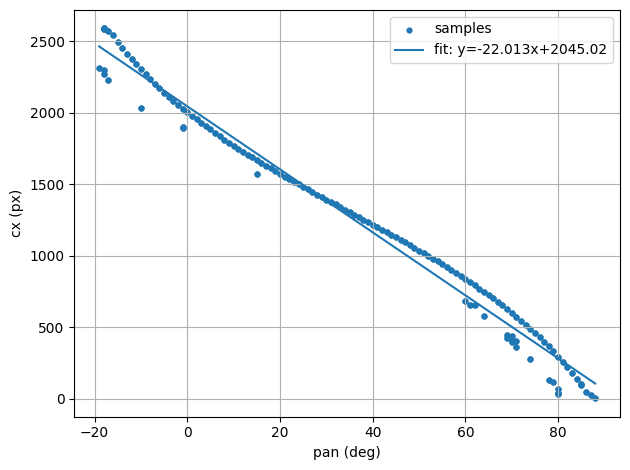

Saved CSV : pan_t0_samples.csv
Saved JSON: pan_t0_fit.json
Saved PLOT: pan_t0_plot.png


In [12]:
out_prefix = "pan_t0"

# CSV
csv_path = f"{out_prefix}_samples.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    cols = ["file","pan_deg","tilt_deg","cx","cy","w","h","conf","cls","W","H"]
    w.writerow(cols)
    for r in rows:
        w.writerow([r.get(c,"") for c in cols])

# JSON
json_path = f"{out_prefix}_fit.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Plot
png_path = f"{out_prefix}_plot.png"
plot_scatter_pan_cx(x, y, metrics["a"], metrics["b"], png_path)

print("Saved CSV :", csv_path)
print("Saved JSON:", json_path)
print("Saved PLOT:", png_path)


[INFO] total rows in CSV: 272
[INFO] kept rows (conf≥0.5): 212


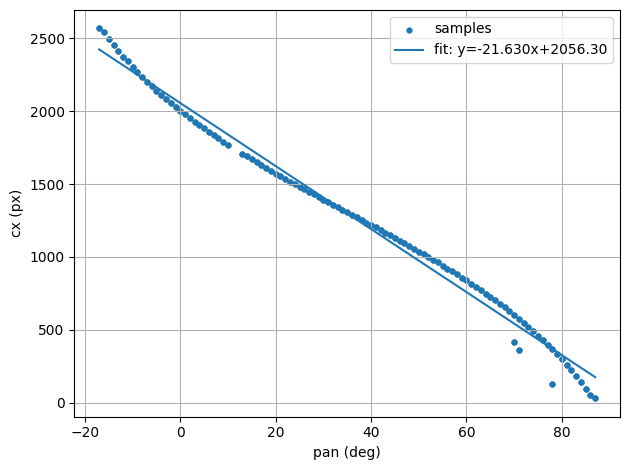

{'a_px_per_deg': -21.630207908763744, 'b_px': 2056.3034474533847}


In [18]:
# CSV → conf 필터 → 산점도 + 선형 피팅
import csv, numpy as np, matplotlib.pyplot as plt

CSV_PATH   = "pan_t0_samples.csv"  # 네 CSV 파일명으로 변경
CONF_MIN   = 0.5                  # 이 값 이상만 플롯
USE_CLASS  = None                  # 특정 클래스만 보려면 숫자, 전체면 None
PAN_RANGE  = None                  # 예: (-10, 30) 범위만 쓰려면 (min,max), 전체면 None

xs, ys, W_frame = [], [], None
total_rows = kept_rows = 0

with open(CSV_PATH, newline="", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        total_rows += 1
        conf = float(row["conf"])
        cls  = int(row["cls"]) if row["cls"] != "" else -1
        pan  = float(row["pan_deg"])
        if conf < CONF_MIN: 
            continue
        if (USE_CLASS is not None) and (cls != USE_CLASS):
            continue
        if PAN_RANGE is not None:
            if not (PAN_RANGE[0] <= pan <= PAN_RANGE[1]):
                continue

        xs.append(pan)
        ys.append(float(row["cx"]))
        if W_frame is None and row.get("W"):
            try:
                W_frame = int(row["W"])
            except:
                W_frame = None
        kept_rows += 1

print(f"[INFO] total rows in CSV: {total_rows}")
print(f"[INFO] kept rows (conf≥{CONF_MIN}"
      f"{'' if USE_CLASS is None else f', class={USE_CLASS}'}"
      f"{'' if PAN_RANGE is None else f', pan∈{PAN_RANGE}'}): {kept_rows}")

if kept_rows >= 3:
    A = np.vstack([xs, np.ones_like(xs)]).T
    a, b = np.linalg.lstsq(A, ys, rcond=None)[0]

    plt.figure()
    plt.scatter(xs, ys, s=12, label="samples")
    xx = np.linspace(min(xs), max(xs), 200)
    yy = a*xx + b
    plt.plot(xx, yy, label=f"fit: y={a:.3f}x+{b:.2f}")
    plt.xlabel("pan (deg)")
    plt.ylabel("cx (px)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print({"a_px_per_deg": float(a), "b_px": float(b)})
else:
    print("⚠️ 필터 후 샘플이 부족합니다. CONF_MIN/USE_CLASS/PAN_RANGE를 조정하세요.")
